In [3]:
import numpy as np
import zarr
import pandas as pd
import dask.array as da
import allel
import fsspec
import matplotlib.pyplot as plt
%matplotlib inline

## Cluster setup

In [4]:
from dask_kubernetes import KubeCluster
cluster = KubeCluster(n_workers=20)
from dask.distributed import Client
client = Client(cluster)
client

distributed.scheduler - INFO - Clear task state
/opt/conda/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)
distributed.scheduler - INFO -   Scheduler at:  tcp://10.33.239.17:42091
distributed.scheduler - INFO -   dashboard at:                    :38135
distributed.scheduler - INFO - Receive client connection: Client-f7bf8a54-aa6a-11ea-82ce-dae38cd91cc9
distributed.core - INFO - Starting established connection


Client Scheduler: tcp://10.33.239.17:42091 Dashboard: /user/alimanfoo@googlemail.com/proxy/38135/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


distributed.scheduler - INFO - Register tcp://10.34.148.2:46777
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.34.148.2:46777
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.34.130.2:37301
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.34.130.2:37301
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.34.131.2:40235
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.34.131.2:40235
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.34.133.2:45037
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.34.133.2:45037
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.34.149.2:46517
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.34.149.2:46517
distributed.c

## Data setup

In [3]:
store_path = 'gcs://ag1000g-release/phase2.AR1/variation/main/zarr/all/ag1000g.phase2.ar1'
store = fsspec.get_mapper(store_path)
callset = zarr.open_consolidated(store)
callset

<zarr.hierarchy.Group '/'>

In [4]:
gt = allel.GenotypeDaskArray(callset['3R/calldata/GT'])
gt

<GenotypeDaskArray shape=(24943504, 1142, 2) dtype=int8>

In [5]:
with fsspec.open('gcs://ag1000g-release/phase2.AR1/samples/samples.meta.txt') as f:
    df_samples = pd.read_csv(f, sep='\t')
df_samples.head()

,ox_code,src_code,population,country,location,site,contributor,contact,year,m_s,sex,n_sequences,mean_coverage,ebi_sample_acc,latitude,longitude
0,AA0040-C,Twifo_Praso__E2,GHcol,Ghana,Twifo Praso,Twifo Praso,David Weetman,David Weetman,2012,M,F,95033368,30.99,ERS311878,5.60858,-1.54926
1,AA0041-C,Twifo_Praso__H3,GHcol,Ghana,Twifo Praso,Twifo Praso,David Weetman,David Weetman,2012,M,F,95843804,31.70,ERS311886,5.60858,-1.54926
2,AA0042-C,Takoradi_C7,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,107420666,35.65,ERS311894,4.91217,-1.77397
3,AA0043-C,Takoradi_H8,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,95993752,29.46,ERS311902,4.91217,-1.77397
4,AA0044-C,Takoradi_D10,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,103044262,33.67,ERS311910,4.91217,-1.77397


## Subset data

### Locate pass variants

In [6]:
loc_pass_variants = callset['3R/variants/FILTER_PASS'][:]
loc_pass_variants

array([False, False, False, ..., False, False, False])

In [8]:
np.count_nonzero(loc_pass_variants)

14481509

### Locate samples in population

In [9]:
pop = 'BFgam'

In [10]:
loc_pop_samples = df_samples[df_samples.population == pop].index.values
loc_pop_samples

array([ 67,  81,  82,  83,  91,  92,  93,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
       121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
       134, 135, 136, 137, 138, 139, 140, 155, 156, 157, 158, 159, 160,
       161, 163, 164, 165, 166, 169, 173, 174, 182, 184, 185, 186, 188,
       189, 191, 192, 194, 197, 203, 204, 205, 206, 207, 210, 211, 214,
       215, 218, 219, 220, 221, 222, 223, 224, 226, 227, 229, 230, 232,
       233])

In [11]:
len(loc_pop_samples)

92

In [12]:
gt_pass_pop = gt.subset(loc_pass_variants, loc_pop_samples)
gt_pass_pop

<GenotypeDaskArray shape=(14481509, 92, 2) dtype=int8>

## Allele count computation

In [14]:
%%time
# watch the dask dashboard while this is computing
ac_pass_pop = gt_pass_pop.count_alleles(max_allele=3).compute()
ac_pass_pop

CPU times: user 3.02 s, sys: 848 ms, total: 3.86 s
Wall time: 5.96 s


<AlleleCountsArray shape=(14481509, 4) dtype=int32>
184   0   0   0
184   0   0   0
184   0   0   0
...
184   0   0   0
180   4   0   0
184   0   0   0

In [15]:
ac_pass_pop.count_segregating()

6022557

## Multi-population test for selection

In [16]:
def population_allele_counts(chrom, pop):
    gtz = callset[chrom]['calldata/GT']
    gt = allel.GenotypeDaskArray(gtz)
    loc_pass_variants = callset[chrom]['variants/FILTER_PASS'][:]
    loc_pop_samples = df_samples[df_samples.population == pop].index.values
    print(pop, 'no. samples:', len(loc_pop_samples))
    gt_pass_pop = gt.subset(loc_pass_variants, loc_pop_samples)
    ac_pass_pop = gt_pass_pop.count_alleles(max_allele=3)
    return ac_pass_pop


def pbs(chrom, pop1, pop2, pop3, window_size=100, min_maf=0.02, normed=True):
    
    # load variant positions
    loc_pass_variants = callset[chrom]['variants/FILTER_PASS'][:]
    pos = callset[chrom]['variants/POS'][:][loc_pass_variants]
    
    # load allele counts
    ac1 = population_allele_counts(chrom, pop1)
    ac2 = population_allele_counts(chrom, pop2)
    ac3 = population_allele_counts(chrom, pop3)
    ac1, ac2, ac3 = da.compute(ac1, ac2, ac3)
    ac1 = allel.AlleleCountsArray(ac1)
    ac2 = allel.AlleleCountsArray(ac2)
    ac3 = allel.AlleleCountsArray(ac3)
    print('finished allele counting')

    # locate segregating variants at sufficient frequency
    ac = ac1 + ac2 + ac3
    loc_seg = ac.is_biallelic_01() & (ac.to_frequencies()[:, :2].min(axis=1) > min_maf)
    print('found', np.count_nonzero(loc_seg), 'segregating variants')
    pos = pos[loc_seg]
    ac1 = ac1[loc_seg]
    ac2 = ac2[loc_seg]
    ac3 = ac3[loc_seg]
    print('finished locating segregating variants')
    
    # setup windows
    starts = allel.moving_statistic(pos, statistic=lambda v: v[0], size=window_size)
    starts[0] = 1  # fix to start of sequence
    ends = np.append(starts[1:] - 1, [np.max(pos)])

    # compute pbs
    res = allel.pbs(ac1, ac2, ac3, window_size=window_size, normed=normed)
    print('finished computing PBS')

    return starts, ends, res


In [20]:
%%time
# watch the dask dashboard
starts, ends, y = pbs('3R', 'BFgam', 'UGgam', 'GW')

BFgam no. samples: 92
UGgam no. samples: 112
GW no. samples: 91
finished allele counting
found 1431465 segregating variants
finished locating segregating variants
finished computing PBS
CPU times: user 15.2 s, sys: 3.85 s, total: 19.1 s
Wall time: 22.5 s


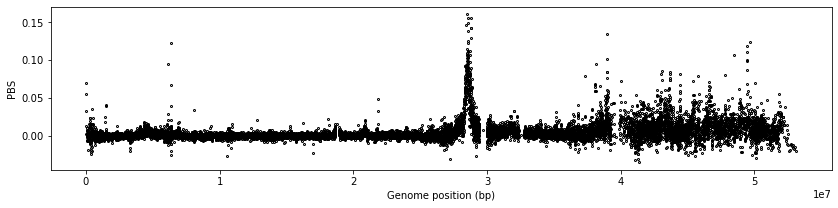

In [18]:
fig, ax = plt.subplots(figsize=(14, 3))
x = (starts + ends) / 2
ax.plot(x, y, marker='o', linestyle=' ', mfc='none', mec='k', markersize=2)
ax.set_xlabel('Genome position (bp)')
ax.set_ylabel('PBS');